In [1]:
import numpy as np 
import geopandas as gpd 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import pandas as pd 
from shapely.geometry import shape 
# from shapely.geometry import Polygon 
import json 
from shapely import wkt 
from shapely.geometry import Point
from shapely.geometry import box
from math import cos, radians
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
import seaborn as sns 
import contextily as ctx
import rioxarray as rxr
import xarray as xr
import matplotlib.patches as mpatches
from windrose import WindroseAxes 

In [2]:
# import easysnowdata

In [4]:
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import censusdata
from rasterstats import zonal_stats

In [15]:
def print_raster_info(da):
    """
    Prints metadata information about a raster dataset.

    Parameters:
    da (xarray.DataArray): The raster dataset opened with rioxarray.
    """
    print(f"""Raster shape: {da.rio.shape}
Raster height: {da.rio.height}
Raster width: {da.rio.width}
Raster nodata value: {da.rio.nodata}
Raster encoded nodata value: {da.rio.encoded_nodata}
Raster number of bands: {da.rio.count}
Raster CRS: {da.rio.crs}
Raster resolution: {da.rio.resolution()}
Raster extent: {da.rio.bounds()}
Raster transform: 
{da.rio.transform()}""")

## Fire Perimeter  

In [16]:
fire_perimeter_fp = '/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/KayDee_Folder/Data/fires_perimeter.geojson'
fire_perimeter_gdf = gpd.read_file(fire_perimeter_fp)
# fire_perimeter_gdf

In [36]:
fire_perimeter_gdf = fire_perimeter_gdf.to_crs('EPSG: 32611')

## Check out Land Use Dataset 

#### Download land cover data (with easynowdata) 

In [17]:
clipped_census = gpd.read_file('clipped_census.geojson')

In [18]:
clipped_lat_lon = clipped_census.copy()

In [19]:
clipped_lat_lon = clipped_lat_lon.to_crs('EPSG:4326')

In [20]:
land_cover_fp = '/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/KayDee_Folder/worldcover_da.tif'

In [21]:
land_cover_da = rxr.open_rasterio(land_cover_fp, masked = True).squeeze()

In [22]:
print_raster_info(land_cover_da)

Raster shape: (24880, 15587)
Raster height: 24880
Raster width: 15587
Raster nodata value: nan
Raster encoded nodata value: 0.0
Raster number of bands: 1
Raster CRS: EPSG:4326
Raster resolution: (8.33333333333334e-05, -8.33333333333334e-05)
Raster extent: (-118.94525, 32.74999999999999, -117.64633333333335, 34.82333333333333)
Raster transform: 
| 0.00, 0.00,-118.95|
| 0.00,-0.00, 34.82|
| 0.00, 0.00, 1.00|


In [23]:
land_cover_da

<xarray.DataArray (y: 24880, x: 15587)> Size: 2GB
[387804560 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 125kB -118.9 -118.9 -118.9 ... -117.6 -117.6 -117.6
  * y            (y) float64 199kB 34.82 34.82 34.82 34.82 ... 32.75 32.75 32.75
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    class_info:     [10.]
    cmap:           <matplotlib.colors.ListedColormap object at 0x7c0e2857f010>
    data_citation:  Zanaga, D., Van De Kerchove, R., De Keersmaecker, W., Sou...
    example_plot:   <function get_esa_worldcover.<locals>.plot_classes at 0x7...
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      map

In [24]:
minx, miny, maxx, maxy = clipped_lat_lon.total_bounds

# Clip the xarray DataArray to the bounding box
clipped_land_cover = land_cover_da.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)

In [25]:
clipped_land_cover

<xarray.DataArray (y: 5561, x: 13091)> Size: 291MB
[72799051 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 105kB -118.7 -118.7 -118.7 ... -117.6 -117.6 -117.6
  * y            (y) float64 44kB 34.44 34.44 34.44 34.44 ... 33.98 33.98 33.98
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    class_info:     [10.]
    cmap:           <matplotlib.colors.ListedColormap object at 0x7c0e2857f010>
    data_citation:  Zanaga, D., Van De Kerchove, R., De Keersmaecker, W., Sou...
    example_plot:   <function get_esa_worldcover.<locals>.plot_classes at 0x7...
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      map

#### Reproject raster 

In [26]:
clipped_land_cover = clipped_land_cover.rio.reproject('EPSG:32611')

In [27]:
print_raster_info(clipped_land_cover)

Raster shape: (6623, 12739)
Raster height: 6623
Raster width: 12739
Raster nodata value: nan
Raster encoded nodata value: 0.0
Raster number of bands: 1
Raster CRS: EPSG:32611
Raster resolution: (7.936655903620901, -7.936655903620901)
Raster extent: (339522.9324986022, 3760191.907569345, 440627.99205482885, 3812756.379619026)
Raster transform: 
| 7.94, 0.00, 339522.93|
| 0.00,-7.94, 3812756.38|
| 0.00, 0.00, 1.00|


In [28]:
clipped_land_cover.attrs['class_info'] = {10: {'name': 'Tree cover', 'color': '#006400'}, 20: {'name': 'Shrubland', 'color': '#FFBB22'}, 30: {'name': 'Grassland', 'color': '#FFFF4C'}, 40: {'name': 'Cropland', 'color': '#F096FF'}, 50: {'name': 'Built-up', 'color': '#FA0000'}, 60: {'name': 'Bare / sparse vegetation', 'color': '#B4B4B4'}, 70: {'name': 'Snow and ice', 'color': '#F0F0F0'}, 80: {'name': 'Permanent water bodies', 'color': '#0064C8'}, 90: {'name': 'Herbaceous wetland', 'color': '#0096A0'}, 95: {'name': 'Mangroves', 'color': '#00CF75'}, 100: {'name': 'Moss and lichen', 'color': '#FAE6A0'}}

In [29]:
clipped_land_cover.attrs

{'AREA_OR_POINT': 'Area',
 'class_info': {10: {'name': 'Tree cover', 'color': '#006400'},
  20: {'name': 'Shrubland', 'color': '#FFBB22'},
  30: {'name': 'Grassland', 'color': '#FFFF4C'},
  40: {'name': 'Cropland', 'color': '#F096FF'},
  50: {'name': 'Built-up', 'color': '#FA0000'},
  60: {'name': 'Bare / sparse vegetation', 'color': '#B4B4B4'},
  70: {'name': 'Snow and ice', 'color': '#F0F0F0'},
  80: {'name': 'Permanent water bodies', 'color': '#0064C8'},
  90: {'name': 'Herbaceous wetland', 'color': '#0096A0'},
  95: {'name': 'Mangroves', 'color': '#00CF75'},
  100: {'name': 'Moss and lichen', 'color': '#FAE6A0'}},
 'cmap': '<matplotlib.colors.ListedColormap object at 0x7c0e2857f010>',
 'data_citation': 'Zanaga, D., Van De Kerchove, R., De Keersmaecker, W., Souverijns, N., Brockmann, C., Quast, R., Wevers, J., Grosu, A., Paccini, A., Vergnaud, S., Cartus, O., Santoro, M., Fritz, S., Georgieva, I., Lesiv, M., Carter, S., Herold, M., Li, Linlin, Tsendbazar, N.E., Ramoino, F., Arino, O

### Land Cover Plot 

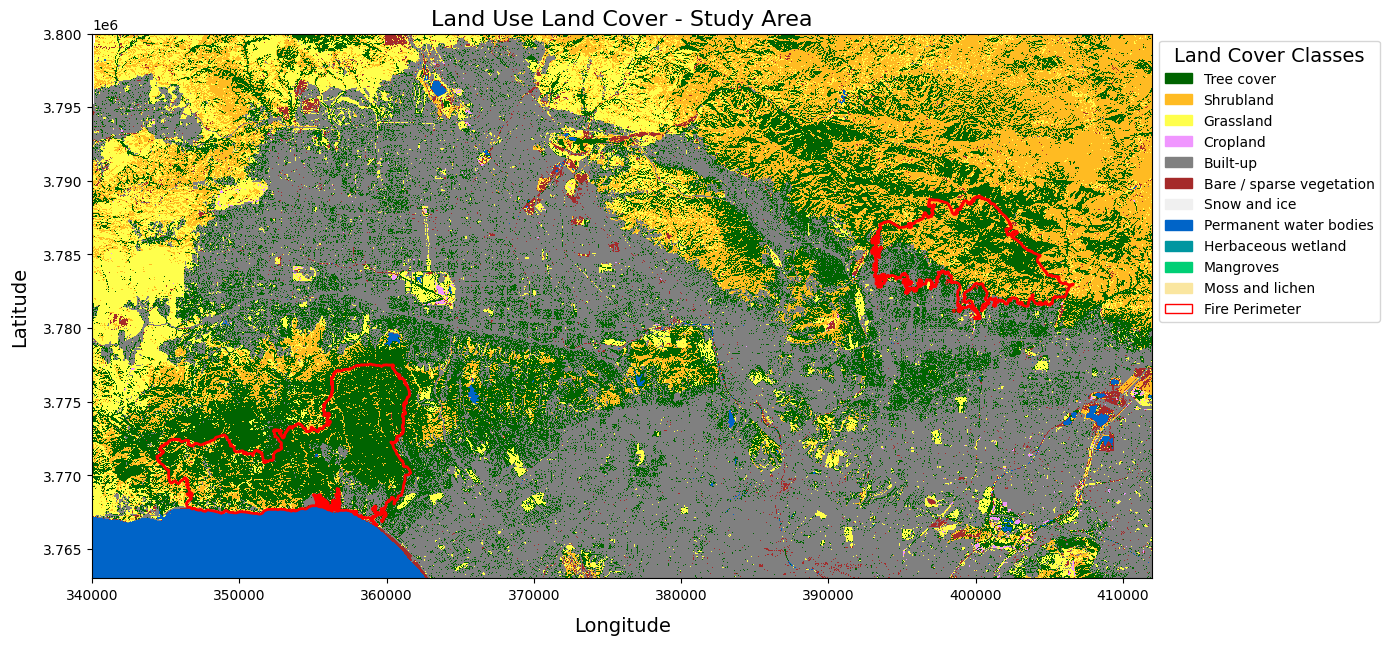

In [37]:
# Define land cover categories and colors 
land_cover_classes = {
    10: {"name": "Tree cover", "color": "#006400"},
    20: {"name": "Shrubland", "color": "#FFBB22"},
    30: {"name": "Grassland", "color": "#FFFF4C"},
    40: {"name": "Cropland", "color": "#F096FF"},
    50: {"name": "Built-up", "color": "gray"},  # Changed Built-up to gray
    60: {"name": "Bare / sparse vegetation", "color": "brown"},
    70: {"name": "Snow and ice", "color": "#F0F0F0"},
    80: {"name": "Permanent water bodies", "color": "#0064C8"},
    90: {"name": "Herbaceous wetland", "color": "#0096A0"},
    95: {"name": "Mangroves", "color": "#00CF75"},
    100: {"name": "Moss and lichen", "color": "#FAE6A0"},
}

# Extract colors and category boundaries
colors = [v["color"] for v in land_cover_classes.values()]
bounds = list(land_cover_classes.keys()) + [max(land_cover_classes.keys()) + 10]  # Add upper bound

custom_cmap = mcolors.ListedColormap(colors)
custom_norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)

fig, ax = plt.subplots(figsize=(14, 10))

clipped_land_cover.plot.imshow(cmap=custom_cmap, norm=custom_norm, ax=ax, add_colorbar=False)

fire_perimeter_gdf.plot(ax=ax, facecolor="none", edgecolor="red", lw = 2)

ax.set_title("Land Use Land Cover - Study Area", fontsize = 16)

# Set Axis Limits
ax.set_xlim(340000, 412000)
ax.set_ylim(3.763e6, 3.80e6)

ax.set_xlabel('Longitude', fontsize = 14, labelpad = 10)
ax.set_ylabel('Latitude', fontsize = 14, labelpad = 10)

fire_patch = mpatches.Patch(edgecolor="red", facecolor="none", label="Fire Perimeter")

# Create Custom Legend
legend_patches = [
    mpatches.Patch(color=v["color"], label=v["name"]) for v in land_cover_classes.values()
]

legend_patches.append(fire_patch)

ax.legend(
    handles=legend_patches, 
    loc="upper left", 
    bbox_to_anchor=(1, 1), 
    fontsize=10, 
    title="Land Cover Classes", title_fontsize = 14
)

fig.tight_layout()

plt.show()


## ERA 5 Data! 

### Read in data file 

In [38]:
from rasterio.warp import Resampling

In [39]:
from metpy.units import units
import metpy.calc as mpcalc

In [40]:
jan_2025_ds = xr.open_dataset("/Users/kwamedonkor/Downloads/LA_ERA5_Land_Hourly/2025/January/data.grib", engine="cfgrib")

Ignoring index file '/Users/kwamedonkor/Downloads/LA_ERA5_Land_Hourly/2025/January/data.grib.5b7b6.idx' older than GRIB file


### Stack time & step dimensions 

In [41]:
jan_2025_ds = jan_2025_ds.stack(valid_time=("time", "step"))

In [42]:
# jan_2025_ds

### Valid Time  

In [43]:
## Convert from object to datetime 

jan_2025_ds = jan_2025_ds.drop_vars(['valid_time', 'time', 'step']).assign_coords(
    valid_time=[t + delta for t, delta in jan_2025_ds.valid_time.values]
)

In [44]:
# jan_2025_ds

### Select Time Range 

In [45]:
jan_2025_ds = jan_2025_ds.sel(valid_time=slice("2025-01-01T00:00", "2025-01-16T23:00"))

In [46]:
jan_2025_ds

<xarray.Dataset> Size: 3MB
Dimensions:     (latitude: 22, longitude: 14, valid_time: 384)
Coordinates:
    number      int64 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 176B 34.8 34.7 34.6 34.5 ... 32.9 32.8 32.7
  * longitude   (longitude) float64 112B -118.9 -118.8 -118.7 ... -117.7 -117.6
  * valid_time  (valid_time) datetime64[ns] 3kB 2025-01-01 ... 2025-01-16T23:...
Data variables:
    t2m         (latitude, longitude, valid_time) float32 473kB 283.3 ... nan
    str         (latitude, longitude, valid_time) float32 473kB -7.416e+06 .....
    sshf        (latitude, longitude, valid_time) float32 473kB -2.961e+06 .....
    u10         (latitude, longitude, valid_time) float32 473kB 0.3862 ... nan
    v10         (latitude, longitude, valid_time) float32 473kB -1.244 ... nan
    tp          (latitude, longitude, valid_time) float32 473kB 1.243e-05 ......
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-17T22:09 GRIB to CDM+CF via cfgrib-0.9.1...

In [47]:
# jan_25_arr = jan_2025_ds['t2m']

### Fire Perimeter & ERA 5 

In [48]:
# fig, ax = plt.subplots(figsize = (14,12))

# # jan_25_arr.isel(valid_time = 18).plot.imshow(ax = ax, cmap = 'jet', cbar_kwargs = {'shrink':0.7})

# jan_25_arr.sel(valid_time = '2025-01-07T23:00:00').plot.imshow(ax = ax, cmap = 'jet', cbar_kwargs = {'shrink':0.7})

# fire_perimeter_gdf.plot(ax=ax, facecolor="none", edgecolor="grey", lw = 2)

# # Set Axis Limits
# ax.set_xlim(340000, 412000)
# ax.set_ylim(3.763e6, 3.80e6)

# ax.set_title('LA County Area', fontsize = 16)

# plt.show()

### Global LA County - Line plot 

#### Define Bounds of LA County 

In [49]:
# xmin = 340000
# xmax = 410000
# ymin = 3.765e6
# ymax = 3.795e6

# la_county_jan_temp = jan_25_arr.rio.clip_box(minx = xmin, miny = ymin, maxx = xmax, maxy = ymax)

## New Workflow 

In [50]:
def process_ds(ds, start_time, end_time):

    # Stack time & step dimensions
    ds = ds.stack(valid_time=("time", "step"))

    # Convert valid_time from object type to datetime
    valid_time_values = [t + delta for t, delta in ds.valid_time.values]
    ds = ds.drop_vars(['valid_time', 'time', 'step']).assign_coords(valid_time=("valid_time", valid_time_values))

    # Ensure valid_time is a DatetimeIndex & sorted
    ds = ds.sortby("valid_time")  # Sort time to be monotonic
    ds = ds.assign_coords(valid_time=("valid_time", pd.to_datetime(ds.valid_time.values)))

    # Select time range
    ds = ds.sel(valid_time=slice(start_time, end_time))

    # Reproject
    ds = ds.rio.write_crs("EPSG:4326").transpose("valid_time", "latitude", "longitude")  # Transpose to ensure correct order
    ds = ds.rio.reproject("EPSG:32611", resampling=Resampling.nearest)

    return ds 


In [51]:
def kelvin_to_fahrenheit(ds):
    # convert to Celsius
    ds['t2m'].values = ds['t2m'].values - 273.15
    ds["t2m"].values = (ds["t2m"].values * 9/5) + 32 

    # Precip (m to mm) 
    ds['tp'].values = (ds['tp'].values)*1000
    
    # update attributes 
    ds['t2m'].attrs["GRIB_units"] = "F"
    ds['t2m'].attrs["units"] = "F"
    ds['tp'].attrs['GRIB_units'] = 'mm'
    ds['tp'].attrs['units'] = 'mm'
    
    return ds 

In [52]:
def filter_study_area(ds, variable):
    
    arr = ds[variable]

    # specify lat & lon limits 
    x_threshold = 440000 
    y_threshold = 3704515  

    arr = arr.where((arr.y > y_threshold) & (arr.x < x_threshold), drop=True)

    ## find absolute (some of the datasets are negative) 
    # arr.values = abs(arr.values)
    
    return arr 

In [53]:
def clip_raster_to_area(arr, reference_gdf):

    ## clip raster using 'fire_perimeter' gdf 
    eaton_clipped = arr.rio.clip([reference_gdf.iloc[0].geometry], all_touched=True) 
    palisades_clipped = arr.rio.clip([reference_gdf.iloc[1].geometry], all_touched=True) 

    return eaton_clipped, palisades_clipped

In [54]:
def calc_humidity(ds):
    
    # get the dew point temp & pressure from the dataset 
    d2m_da = ds['d2m']
    sp_da = ds['sp']    

    # apply metpy.quantify()
    d2m_da = d2m_da.metpy.quantify()
    sp_da = sp_da.metpy.quantify()

    # calculate the specific humidity 
    aqh2m = mpcalc.specific_humidity_from_dewpoint(sp_da, d2m_da)

    # return the specific humidity array 
    return aqh2m

### Read in Dataset(s)  

In [55]:
jan_2025_ds_new = xr.open_dataset("/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/KayDee_Folder/ERA_5_Land_Final/New_All_Data_Jan_2025/c339fc2aac17dff280aa3fb5f9bf8e21.grib", engine="cfgrib")

Ignoring index file '/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/KayDee_Folder/ERA_5_Land_Final/New_All_Data_Jan_2025/c339fc2aac17dff280aa3fb5f9bf8e21.grib.5b7b6.idx' incompatible with GRIB file


In [56]:
dec_2024_ds_new = xr.open_dataset("/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/KayDee_Folder/ERA_5_Land_Final/Dec_All_Data_24/74294c864c20d515735bca74efb95063.grib", engine="cfgrib")

Ignoring index file '/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/KayDee_Folder/ERA_5_Land_Final/Dec_All_Data_24/74294c864c20d515735bca74efb95063.grib.5b7b6.idx' incompatible with GRIB file


In [57]:
nov_2024_ds_new = xr.open_dataset("/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/KayDee_Folder/ERA_5_Land_Final/Nov_All_Data_24/818e69ff5fbfa2a8f8453b96d84a3624.grib", engine="cfgrib")

Ignoring index file '/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/KayDee_Folder/ERA_5_Land_Final/Nov_All_Data_24/818e69ff5fbfa2a8f8453b96d84a3624.grib.5b7b6.idx' incompatible with GRIB file


In [58]:
oct_2024_ds_new = xr.open_dataset("/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/KayDee_Folder/ERA_5_Land_Final/October_24_New/781b81b17a74f55535c43496933332cf.grib", engine = 'cfgrib')

In [59]:
sept_2024_ds_new = xr.open_dataset('/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/KayDee_Folder/ERA_5_Land_Final/September_24_New/62807da8ed24ef685f83228e175892f6.grib', engine = 'cfgrib')

In [60]:
aug_2024_ds_new = xr.open_dataset('/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/KayDee_Folder/ERA_5_Land_Final/August_24_New/c5baaeb906c02558cc4c2e560fd19466.grib', engine = 'cfgrib')

jul_2024_ds_new = xr.open_dataset('/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/KayDee_Folder/ERA_5_Land_Final/July_24_New/45c34445d87f4de10dd8513b08012928.grib', engine = 'cfgrib')

jun_2024_ds_new = xr.open_dataset('/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/KayDee_Folder/ERA_5_Land_Final/June_24_New/272ed8a0562d646733a445b45c7fb0b9.grib', engine = 'cfgrib')

may_2024_ds_new = xr.open_dataset('/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/KayDee_Folder/ERA_5_Land_Final/May_24_New/dce315dc786a8edc6564819698af9097.grib', engine = 'cfgrib')

apr_2024_ds_new = xr.open_dataset('/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/KayDee_Folder/ERA_5_Land_Final/April_24_New/ddd0349747e7f61ce0ed795713f47ddc.grib', engine = 'cfgrib')

mar_2024_ds_new = xr.open_dataset('/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/KayDee_Folder/ERA_5_Land_Final/March_24_New/7f23783d757616f10ec14ade2d8c20c.grib', engine = 'cfgrib')

feb_2024_ds_new = xr.open_dataset('/Users/kwamedonkor/Downloads/UW/2nd Year/CEWA Project/KayDee_Folder/ERA_5_Land_Final/February_24_New/45977af2b9a9c91268fb8934533c87cb.grib', engine = 'cfgrib')

In [61]:
list_datasets = [jan_2025_ds_new, dec_2024_ds_new, nov_2024_ds_new, oct_2024_ds_new, sept_2024_ds_new, aug_2024_ds_new, jul_2024_ds_new, jun_2024_ds_new, may_2024_ds_new, apr_2024_ds_new, mar_2024_ds_new, feb_2024_ds_new]

In [62]:
combined_ds = xr.concat(list_datasets, dim="time")

combined_ds = combined_ds.sortby("time")

### Define Global Start & End Times  

In [63]:
start_time = "2024-02-01T00:00"
end_time = "2025-01-31T23:00"

In [64]:
combined_ds  = process_ds(combined_ds, start_time, end_time)

In [65]:
# Kelvin to F 
combined_ds = kelvin_to_fahrenheit(combined_ds)

In [66]:
combined_ds

<xarray.Dataset> Size: 93MB
Dimensions:      (x: 13, y: 22, valid_time: 9048)
Coordinates:
  * x            (x) float64 104B 3.178e+05 3.284e+05 ... 4.34e+05 4.445e+05
  * y            (y) float64 176B 3.847e+06 3.837e+06 ... 3.636e+06 3.626e+06
  * valid_time   (valid_time) datetime64[ns] 72kB 2024-02-01 ... 2025-01-31T2...
    surface      float64 8B 0.0
    number       int64 8B 0
    spatial_ref  int64 8B 0
Data variables:
    d2m          (valid_time, y, x) float32 10MB 272.0 273.7 275.1 ... nan nan
    t2m          (valid_time, y, x) float32 10MB 48.7 51.19 53.07 ... nan nan
    slhf         (valid_time, y, x) float32 10MB -3.196e+06 -3.72e+06 ... nan
    sshf         (valid_time, y, x) float32 10MB -3.412e+06 -2.104e+06 ... nan
    e            (valid_time, y, x) float32 10MB -0.001278 -0.001487 ... nan nan
    u10          (valid_time, y, x) float32 10MB -0.9798 -0.685 ... nan nan
    v10          (valid_time, y, x) float32 10MB 2.976 3.166 3.355 ... nan nan
    sp           (valid_time, y, x) float32 10MB 8.393e+04 8.646e+04 ... nan nan
    tp           (valid_time, y, x) float32 10MB 0.0004351 0.0004351 ... nan nan
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-03-17T22:09 GRIB to CDM+CF via cfgrib-0.9.1...

### Variables of Interest 

### Temp 

In [67]:
# Get Array for 't2m'
temp_arr = filter_study_area(combined_ds, 't2m')

# Raster for Palisades & Eaton 
eaton_temp_da, palisades_temp_da = clip_raster_to_area(temp_arr, fire_perimeter_gdf)

### Evaporation  

In [68]:
# Get Array for 'e'
evap_arr = filter_study_area(combined_ds, 'e')

# Raster for Palisades & Eaton 
eaton_evap_da, palisades_evap_da = clip_raster_to_area(evap_arr, fire_perimeter_gdf)

### Precip 

In [69]:
# Get Array for 'tp'
tp_arr = filter_study_area(combined_ds, 'tp')

# Raster for Palisades & Eaton 
eaton_tp_da, palisades_tp_da = clip_raster_to_area(tp_arr, fire_perimeter_gdf)

### SSHF 

In [70]:
# Get Array for 'sshf'
sshf_arr = filter_study_area(combined_ds, 'sshf')

# Raster for Palisades & Eaton 
eaton_sshf_da, palisades_sshf_da = clip_raster_to_area(sshf_arr, fire_perimeter_gdf)

### Specific humidity data 

In [71]:
aqh2m = calc_humidity(combined_ds)

In [72]:
# aqh2m.mean(dim = ['x', 'y']).plot()

### Show spatial plots of {var} for just January 

In [73]:
# jan_daily_temp_arr = combined_arr.resample(valid_time="1D").max() 

# jan_daily_temp_arr.plot.imshow(
#     col="valid_time",  
#     col_wrap=4,  
#     cmap="jet",
#     figsize=(16, 12),
#     aspect=1.2
# )

### Line Plots - Plotting Max Value 

In [74]:

def plot_temp_trends(dataset1, dataset2, timestamp_1, timestamp_2, title1, title2, ylabel, xlabel="Day of Month"):
    
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True)
    
    ##### Dataset 1 Plot 
    dataset1.max(dim=['x', 'y']).plot(ax=axs[0], color='orange', label='Max')
    axs[0].legend()
    axs[0].set_xlabel('', labelpad=15)
    axs[0].set_ylabel(ylabel, labelpad=15)
    axs[0].set_title(title1, pad=10)

    # Add vertical lines for start and end times
    axs[0].axvline(timestamp_1, color='red', linestyle='--', linewidth=1.5, label="Start Time")
    axs[0].axvline(timestamp_2, color='red', linestyle='--', linewidth=1.5, label="End Time")
    
    ##### Dataset 2 Plot 
    dataset2.max(dim=['x', 'y']).plot(ax=axs[1], color='lightblue', label='Max')
    axs[1].legend()
    axs[1].set_xlabel(xlabel, labelpad=15)
    axs[1].set_ylabel(ylabel, labelpad=15)
    axs[1].set_title(title2, pad=10)
    
    # Add vertical lines for start and end times (optional)
    # axs[1].axvline(timestamp_1, color='red', linestyle='--', linewidth=1.5, label="Start Time")
    # axs[1].axvline(timestamp_2, color='red', linestyle='--', linewidth=1.5, label="End Time")

    # Adjust the layout to prevent overlap
    fig.tight_layout()
    plt.show()


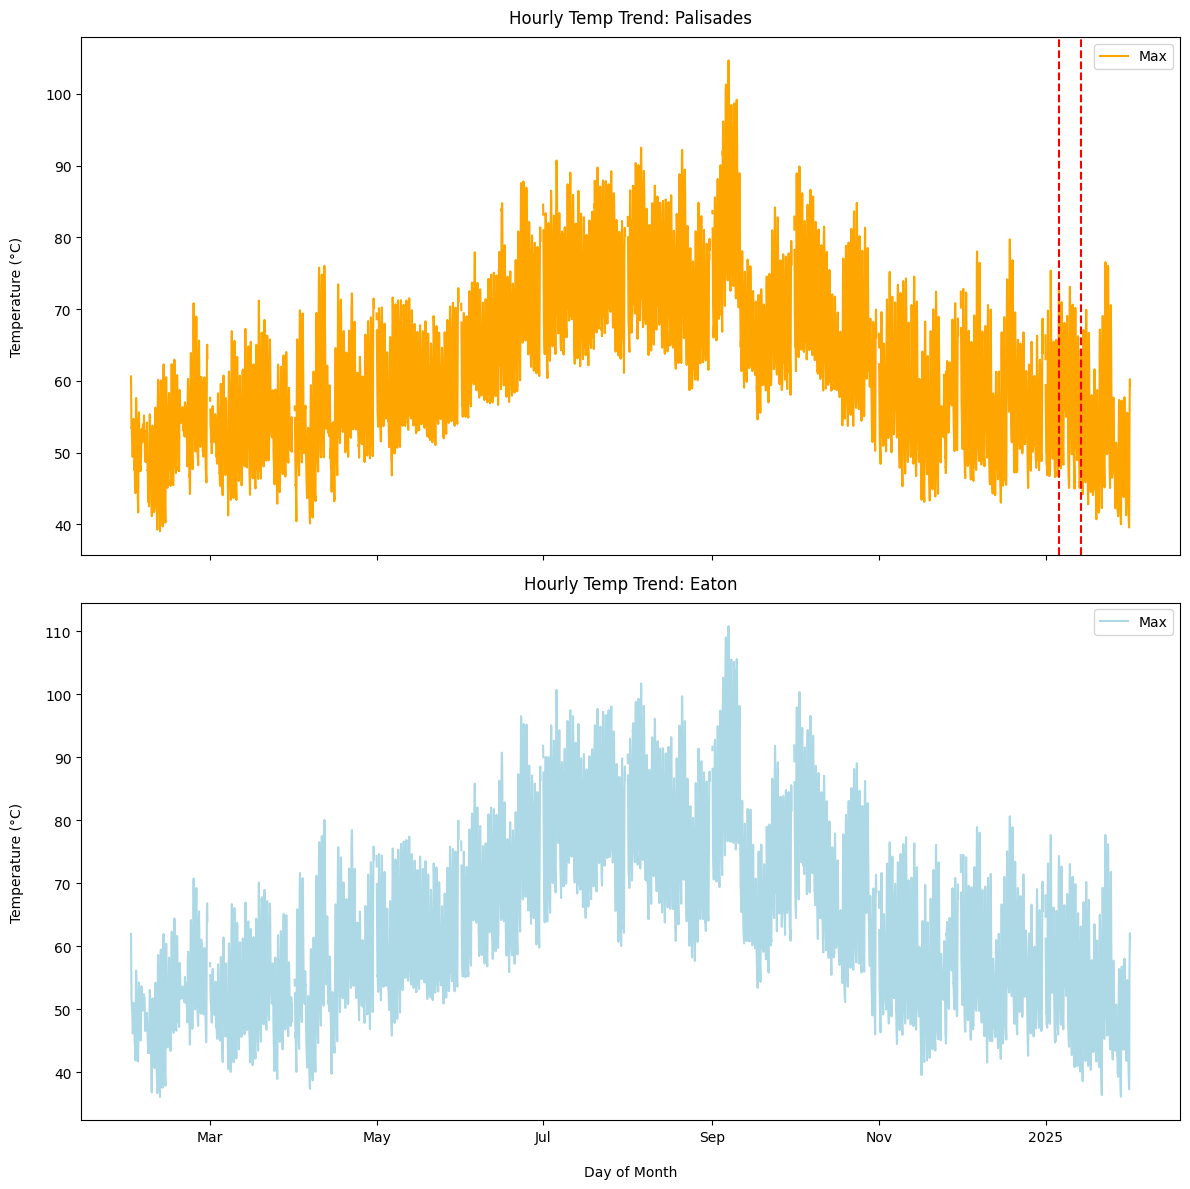

In [75]:
# Fire Period 
timestamp_1 = np.datetime64("2025-01-06T01:00:00")
timestamp_2 = np.datetime64("2025-01-14T01:00:00")

plot_temp_trends(
    dataset1=palisades_temp_da, 
    dataset2=eaton_temp_da, 
    timestamp_1=timestamp_1, 
    timestamp_2=timestamp_2, 
    title1="Hourly Temp Trend: Palisades", 
    title2="Hourly Temp Trend: Eaton", 
    ylabel="Temperature (°C)"
)

### Findings 
* Very high temperature in the Summer (lines up with heat wave during the period)
* Peak of about 110 degrees F
* Temperatures before & during the fires were not an anomaly (they were not unusually high) 

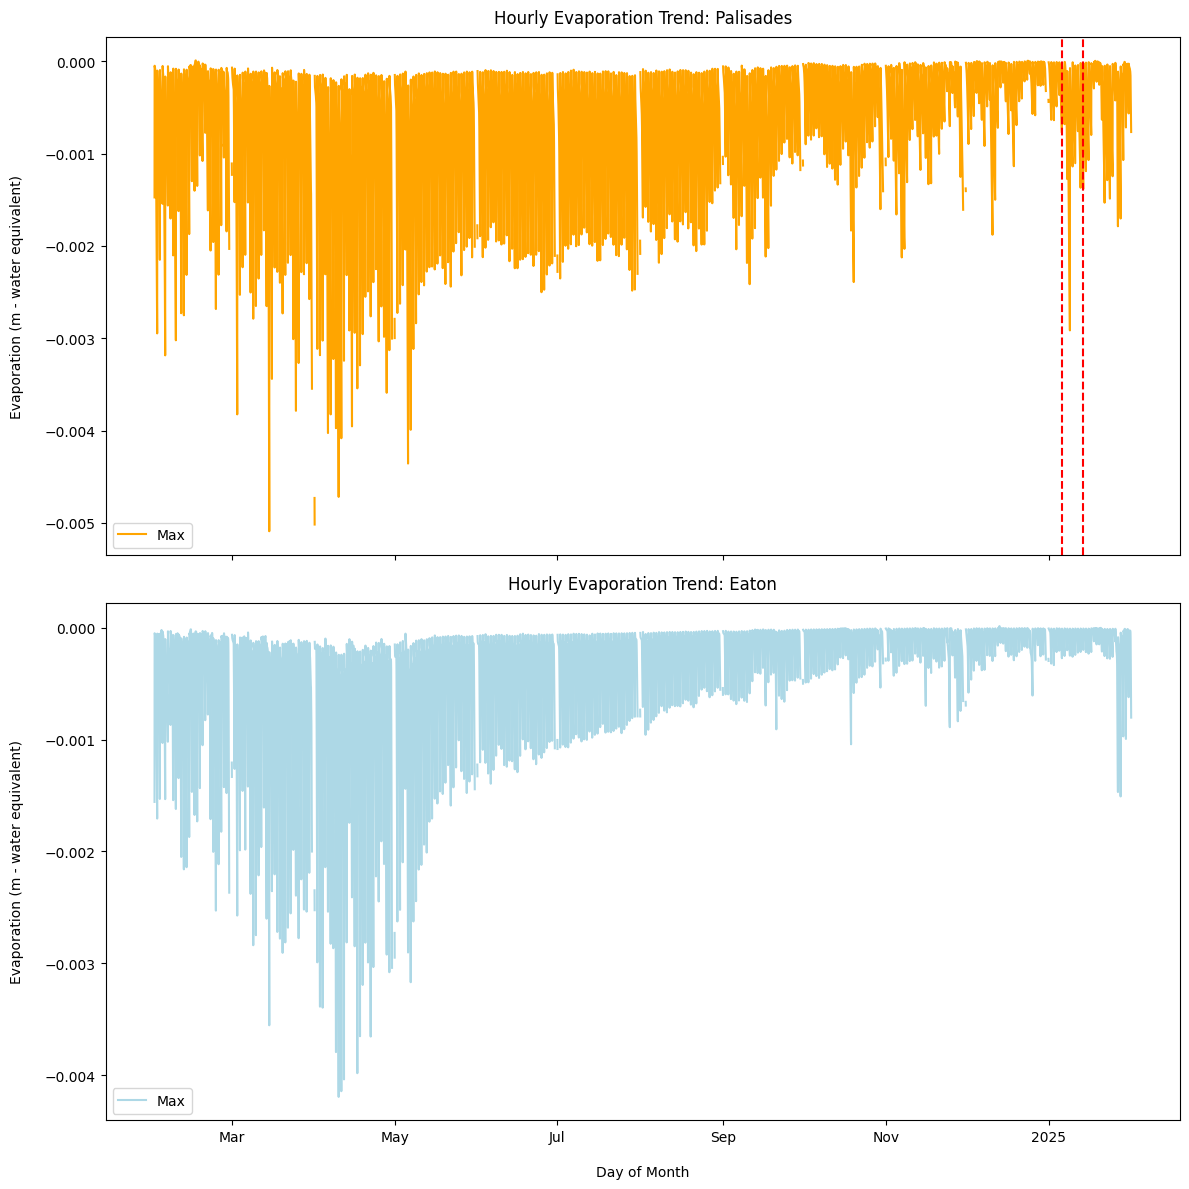

In [76]:
# Fire Period 
timestamp_1 = np.datetime64("2025-01-06T01:00:00")
timestamp_2 = np.datetime64("2025-01-14T01:00:00")

plot_temp_trends(
    dataset1=palisades_evap_da, 
    dataset2=eaton_evap_da, 
    timestamp_1=timestamp_1, 
    timestamp_2=timestamp_2, 
    title1="Hourly Evaporation Trend: Palisades", 
    title2="Hourly Evaporation Trend: Eaton", 
    ylabel="Evaporation (m - water equivalent)"
)

### Findings 
* High Evaporation values mean a lot of moisture is leaving the ground from HEAT
* Can see spike in January during the fires
* Evaporation was low in the summer because humidity was high during the same period 

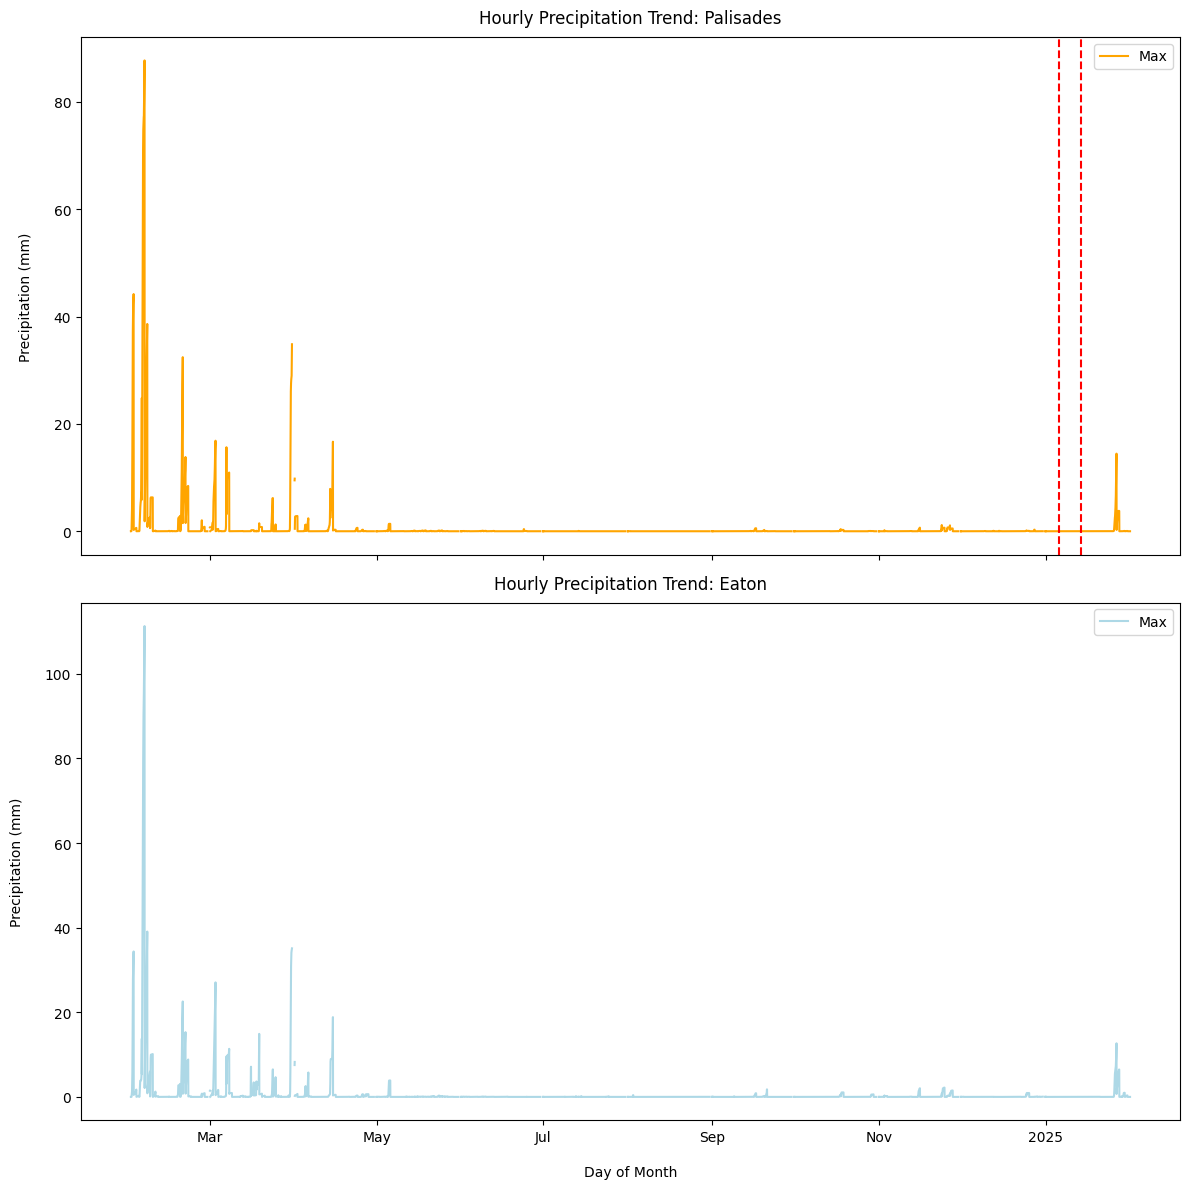

In [77]:
# Fire Period 
timestamp_1 = np.datetime64("2025-01-06T01:00:00")
timestamp_2 = np.datetime64("2025-01-14T01:00:00")

plot_temp_trends(
    dataset1=palisades_tp_da, 
    dataset2=eaton_tp_da, 
    timestamp_1=timestamp_1, 
    timestamp_2=timestamp_2, 
    title1="Hourly Precipitation Trend: Palisades", 
    title2="Hourly Precipitation Trend: Eaton", 
    ylabel="Precipitation (mm)"
)

### Findings 
* Long periods without rain (if this precip data is correct)
* Lots of rains early last year (Winter & Spring) 

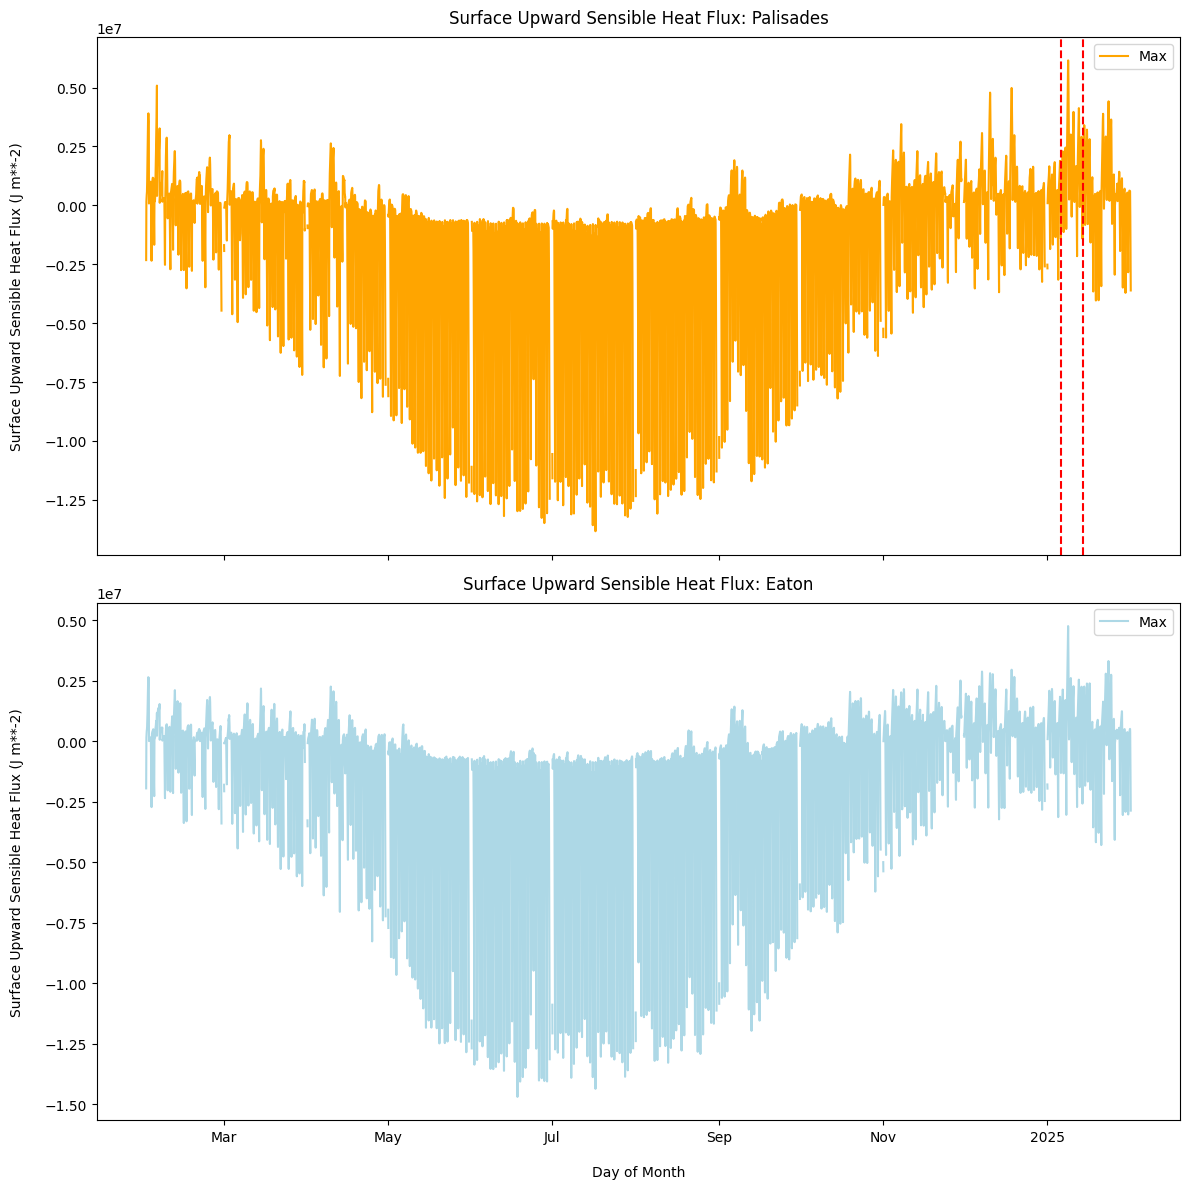

In [78]:
# Fire Period 
timestamp_1 = np.datetime64("2025-01-06T01:00:00")
timestamp_2 = np.datetime64("2025-01-14T01:00:00")

plot_temp_trends(
    dataset1=palisades_sshf_da, 
    dataset2=eaton_sshf_da, 
    timestamp_1=timestamp_1, 
    timestamp_2=timestamp_2, 
    title1="Surface Upward Sensible Heat Flux: Palisades", 
    title2="Surface Upward Sensible Heat Flux: Eaton", 
    ylabel="Surface Upward Sensible Heat Flux (J m**-2)"
)

### Findings 
* sshf = sensible_heat_flux (can see spike during fire) 

### Surface Upward Sensible Heat Flux
* Refers to the transfer of heat from the Earth's surface to the atmosphere due to temperature differences between the surface and the air above it. It is one of the key components of the surface energy balance.
* Positive values indicate heat moving from the surface to the atmosphere.
* Negative values indicate heat moving from the atmosphere to the surface.

In [79]:
median_value = np.nanmedian(aqh2m.values)
median_value

0.0069301194

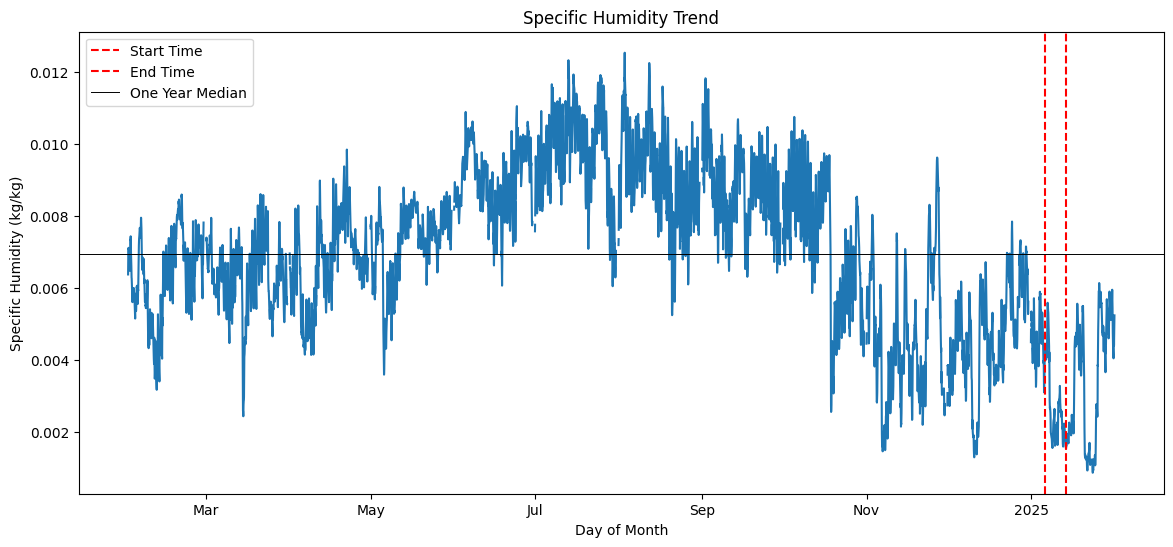

In [80]:
fig, ax = plt.subplots(figsize = (14,6))

aqh2m.mean(dim = ['x', 'y']).plot(ax = ax);

ax.axvline(timestamp_1, color='red', linestyle='--', linewidth=1.5, label="Start Time")
ax.axvline(timestamp_2, color='red', linestyle='--', linewidth=1.5, label="End Time")

ax.axhline(median_value, color = 'k', lw = 0.7, label = 'One Year Median')

ax.legend()
ax.set_ylabel('Specific Humidity (kg/kg)')
ax.set_xlabel('Day of Month')
ax.set_title('Specific Humidity Trend');

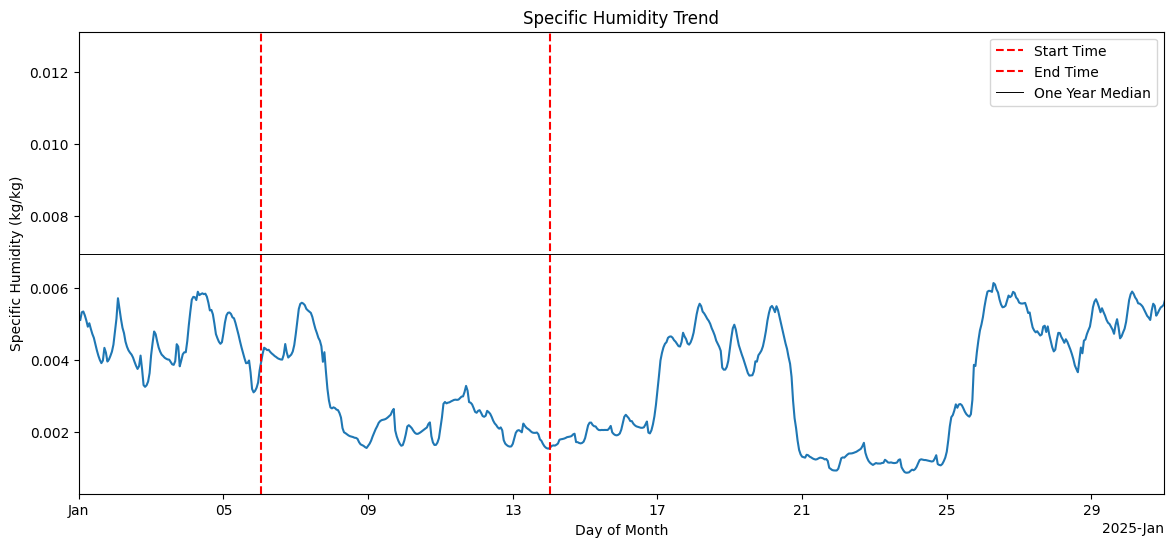

In [81]:
fig, ax = plt.subplots(figsize = (14,6))

aqh2m.mean(dim = ['x', 'y']).plot(ax = ax);

ax.axvline(timestamp_1, color='red', linestyle='--', linewidth=1.5, label="Start Time")
ax.axvline(timestamp_2, color='red', linestyle='--', linewidth=1.5, label="End Time")

ax.axhline(median_value, color = 'k', lw = 0.7, label = 'One Year Median')

## Set X limits 
ax.set_xlim(np.datetime64('2025-01-01T00:00'), np.datetime64('2025-01-31T00:00'))

ax.legend()
ax.set_ylabel('Specific Humidity (kg/kg)')
ax.set_xlabel('Day of Month')
ax.set_title('Specific Humidity Trend');

In [82]:
aqh2m_study_period = aqh2m.sel(valid_time = slice('2025-01-01T00:00', '2025-01-31T23:00'))

In [83]:
aqh2m_mean = aqh2m_study_period.mean(dim = ['x', 'y']) ## mean over all pixels 
aqh2m_mean = np.nanmean(aqh2m_mean)

In [84]:
## select specific humidity from Sept to Date 

aqh2m_sept_date = aqh2m.sel(valid_time = slice('2024-09-01T00:00', '2024-12-31T23:00'))

In [85]:
less_than_median_maska_aqh2m = aqh2m_sept_date < median_value
arr_less_than_median_aqh2m = aqh2m_sept_date.where(less_than_median_maska_aqh2m, drop = True)

# find average over all pixels 
arr_less_than_median_aqh2m = arr_less_than_median_aqh2m.mean(dim = ['x', 'y'])

In [86]:
print(f"The humidity in January was {(aqh2m_mean*100/median_value):.2f}% of the 1-year median value.")
print(f"From September till 31st December, average specific humidity was lower than 1-year median for approx {arr_less_than_median_aqh2m.size} hours or {(arr_less_than_median_aqh2m.size/24):.2f} days.")

The humidity in January was 49.43% of the 1-year median value.
From September till 31st December, average specific humidity was lower than 1-year median for approx 2869 hours or 119.54 days.


### Findings 
* Humidity levels dropping below 1-year median following the summer
* High average temperature & low humidity likely contributed to increased dryness 

#### Humidity   
* Very dry air (deserts, cold regions, upper atmosphere) → 0 to 4 g/kg (0.000 to 0.004 kg/kg)
* Typical mid-latitude conditions → 4 to 10 g/kg (0.004 to 0.010 kg/kg)

### Wind Line Plots  

#### Calculate Wind Speed & Direction  

In [87]:
u10_da = combined_ds['u10']
v10_da = combined_ds['v10']

wind_speed_10m = np.sqrt(u10_da**2 + v10_da**2)
wind_dir_10m = np.arctan2(-u10_da, -v10_da) * (180 / np.pi)

In [88]:
median_wind = np.nanmedian(wind_speed_10m.values)
median_wind

1.7042114

In [89]:
### speed in miles per hour 

gentle_breeze = 10 
moderate_breeze = 15

In [90]:
### speed in metres / s 

gentle_breeze_m_s = gentle_breeze / 2.237
moderate_breeze_m_s = moderate_breeze / 2.237

In [91]:
gentle_breeze_m_s

4.470272686633884

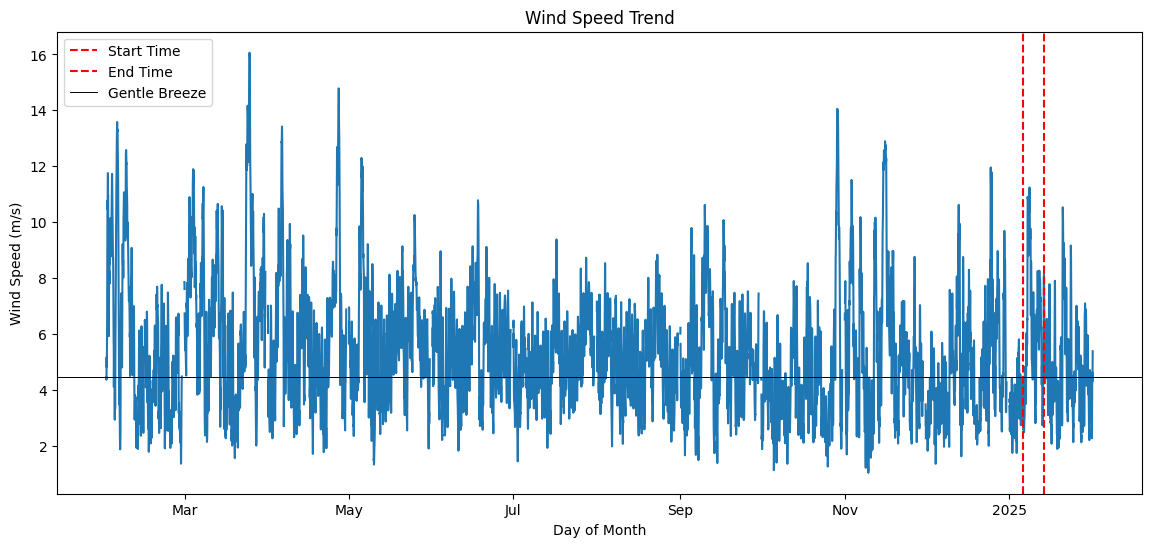

In [92]:
fig, ax = plt.subplots(figsize = (14,6))

wind_speed_10m.max(dim = ['x', 'y']).plot(ax = ax)

ax.axvline(timestamp_1, color='red', linestyle='--', linewidth=1.5, label="Start Time")
ax.axvline(timestamp_2, color='red', linestyle='--', linewidth=1.5, label="End Time")

ax.axhline(gentle_breeze_m_s, color = 'k', lw = 0.7, label = 'Gentle Breeze')

ax.legend()
ax.set_ylabel('Wind Speed (m/s)')
ax.set_xlabel('Day of Month')
ax.set_title('Wind Speed Trend');

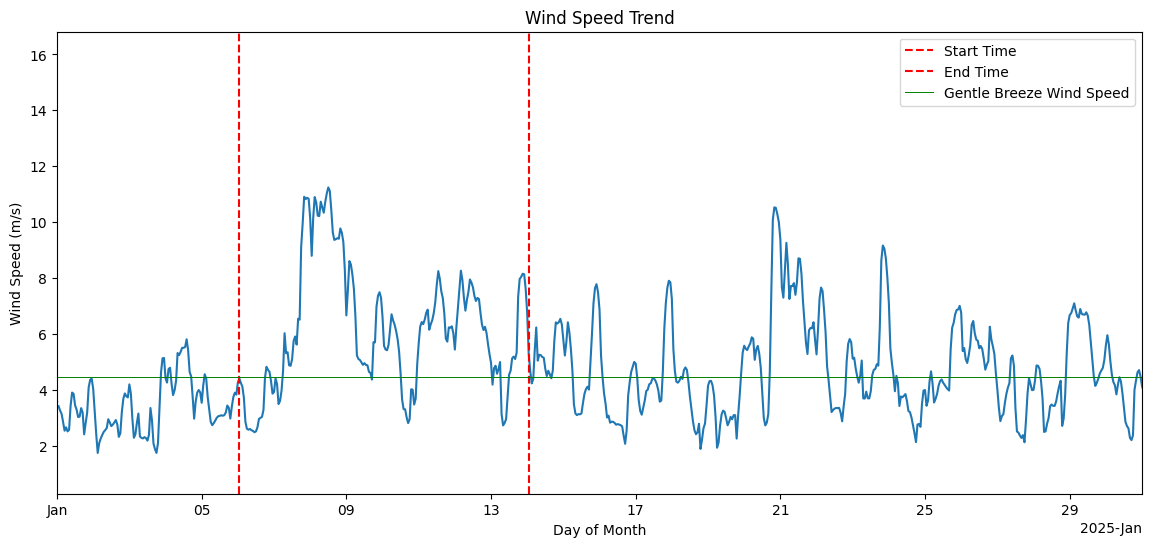

In [93]:
fig, ax = plt.subplots(figsize = (14,6))

wind_speed_10m.max(dim = ['x', 'y']).plot(ax = ax)

ax.axvline(timestamp_1, color='red', linestyle='--', linewidth=1.5, label="Start Time")
ax.axvline(timestamp_2, color='red', linestyle='--', linewidth=1.5, label="End Time")

# ax.axhline(median_wind, color = 'k', lw = 0.7, label = 'One Year Median')
ax.axhline(gentle_breeze_m_s, color = 'green', lw = 0.7, label = "Gentle Breeze Wind Speed")

## Set X limits 
ax.set_xlim(np.datetime64('2025-01-01T00:00'), np.datetime64('2025-01-31T00:00'))

ax.legend()
ax.set_ylabel('Wind Speed (m/s)')
ax.set_xlabel('Day of Month')
ax.set_title('Wind Speed Trend');

### Some statistics 

#### Max Wind Speed & Day of Occurrence 

In [94]:
# filter out 1st to 31st Jan 
wind_speed_study_period = wind_speed_10m.sel(valid_time = slice('2025-01-01T00:00', '2025-01-31T23:00'))

In [95]:
max_wind_jan = wind_speed_study_period.max()
# min_wind_jan = wind_speed_study_period.min()

In [96]:
max_time = wind_speed_study_period.where(wind_speed_study_period == wind_speed_study_period.max(), drop=True).valid_time.values
formatted_time = pd.to_datetime(max_time[0]).strftime('%d %b %Y')

#### Hours of high wind speeds  

In [97]:
wind_speed_study_period_mean = wind_speed_study_period.mean(dim = ['x', 'y'])

In [98]:
# Wind Speed Threshold (m/s) 
threshold = gentle_breeze_m_s 

hours_above_threshold = (wind_speed_study_period_mean > threshold).sum().item()

#### Wind speeds before & during the fires 

In [99]:
# wind_speed_before = wind_speed_10m.sel(valid_time = slice('2025-01-01T00:00', '2025-01-31T23:00'))
wind_speed_before = wind_speed_10m.sel(valid_time = slice('2025-01-01T00:00', '2025-01-06T23:00'))

wind_speed_during = wind_speed_10m.sel(valid_time = slice('2025-01-07T00:00', '2025-01-16T23:00'))

In [100]:
wind_speed_before_max = wind_speed_before.max(dim = ['x', 'y']).mean()

wind_speed_during_max = wind_speed_during.max(dim = ['x', 'y']).mean()

In [101]:
print(f"Maximum Wind Speed: {max_wind_jan:.2f} m/s which occurred on {formatted_time}.")
print(f"Average Wind speed was above {threshold:.2f} m/s which represents gentle breeze wind speed for approximately {hours_above_threshold} hours.")
print(f"Average Max Value of Wind Speeds during the fires were approximately {(wind_speed_during_max/wind_speed_before_max):.0f} times the value of same before the fires.")

Maximum Wind Speed: 11.24 m/s which occurred on 08 Jan 2025.
Average Wind speed was above 4.47 m/s which represents gentle breeze wind speed for approximately 42 hours.
Average Max Value of Wind Speeds during the fires were approximately 2 times the value of same before the fires.


### Findings 
* Wind Speeds were highest on the 8th of January (a day after the onset of the fires)
* Wind Speeds during fire were twice as high as before the fires
* High Wind Speeds coincide with the Santa Ana winds 

In [102]:
# v10_da

### Wind Quiver Plots 

#### Define time period  

In [103]:
u10_arr = u10_da.sel(valid_time = slice('2025-01-05T00:00', '2025-01-12T23:00'))
u10_arr_daily = u10_arr.resample(valid_time="1D").max() 

In [104]:
v10_arr = v10_da.sel(valid_time = slice('2025-01-05T00:00', '2025-01-12T23:00'))
v10_arr_daily = v10_arr.resample(valid_time="1D").max() 

In [105]:
def plot_wind_vectors_by_day(u10_arr_daily, v10_arr_daily, land_cover_classes, fire_perimeter_gdf, clipped_land_cover, custom_cmap, custom_norm):

    # Calculate number of days
    num_days = len(u10_arr_daily.valid_time)  # Number of days
    num_rows = np.ceil(num_days / 1).astype(int)  
    num_cols = 1  

    # Create the figure and set up the subplots
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 4*num_rows), sharex=True, sharey=True)

    # Flatten the 2D array of axes if necessary
    axs = axs.flatten() if num_days > 1 else [axs]

    for i, time_point in enumerate(u10_arr_daily.valid_time):
        ax = axs[i]
        
        # Plot the land cover
        clipped_land_cover.plot.imshow(cmap=custom_cmap, norm=custom_norm, ax=ax, add_colorbar=False)

        # Plot the fire perimeter
        fire_perimeter_gdf.plot(ax=ax, facecolor="none", edgecolor="red", lw=2)

        # Plot the wind vectors for the current day
        ax.quiver(
            combined_ds['x'], combined_ds['y'],
            u10_arr_daily.isel(valid_time=i), v10_arr_daily.isel(valid_time=i)
        )
        
        # Format the title using pd.to_datetime and strftime
        day_str = pd.to_datetime(u10_arr_daily.valid_time[i].values).strftime('%d %b')
        ax.set_title(f'Wind Vectors at 10m: {day_str}')

        # Set labels
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

        # Add legend
        fire_patch = mpatches.Patch(edgecolor="red", facecolor="none", label="Fire Perimeter")
        legend_patches = [
            mpatches.Patch(color=v["color"], label=v["name"]) for v in land_cover_classes.values()
        ]
        legend_patches.append(fire_patch)

        ax.legend(
            handles=legend_patches, 
            loc="upper left", 
            bbox_to_anchor=(1, 1), 
            fontsize=10, 
            title="Land Cover Classes", title_fontsize=14
        )

        # Set Axis Limits
        ax.set_xlim(340000, 412000)
        ax.set_ylim(3.763e6, 3.80e6)

    # Hide any empty subplots
    for j in range(i+1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

#### Plot of daily maximum values (main focus on Magnitude) 

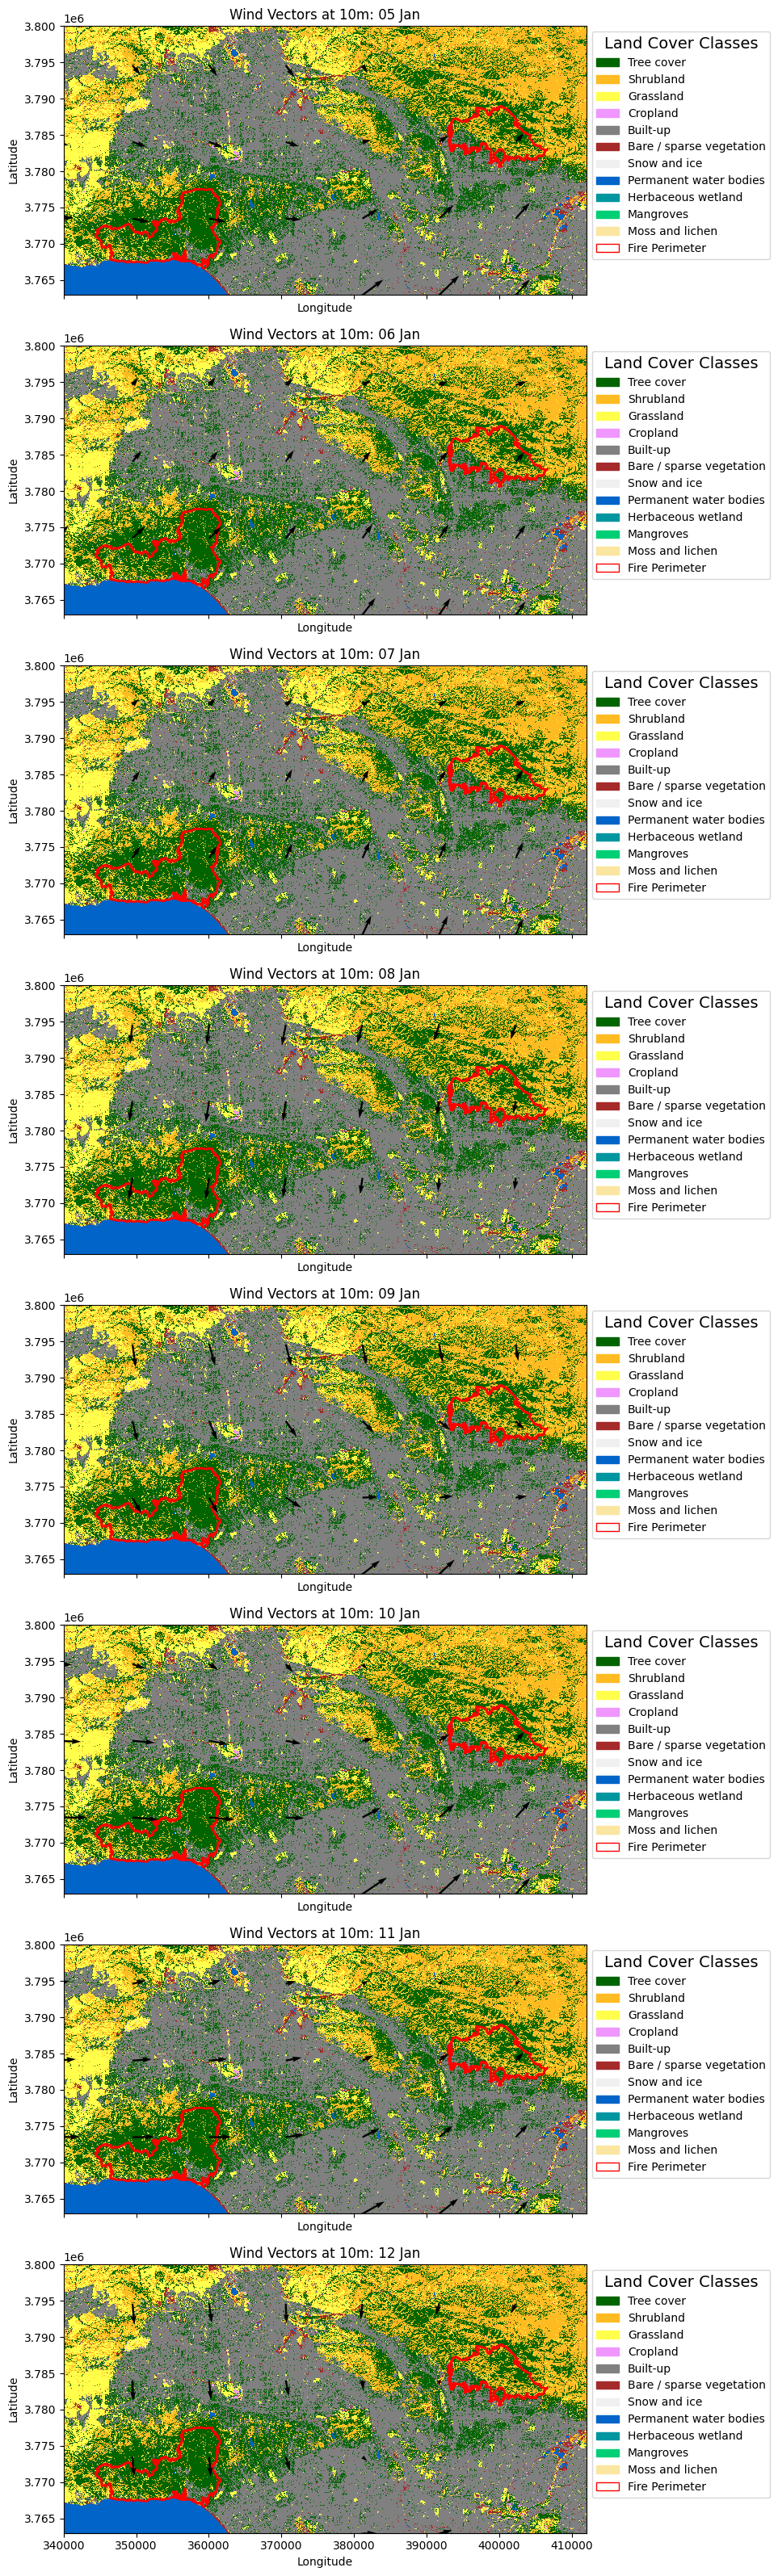

In [106]:
plot_wind_vectors_by_day(u10_arr_daily, v10_arr_daily, land_cover_classes, fire_perimeter_gdf, clipped_land_cover, custom_cmap, custom_norm)

#### Wind Rose 

In [107]:

def plot_wind_rose_per_day(u10_arr, v10_arr, location = 'Eaton'):
    df = pd.DataFrame({
        'u': u10_arr.values.ravel(),
        'v': v10_arr.values.ravel(),
    }, index=pd.to_datetime(u10_arr.valid_time.values))

    df['wind_speed'] = np.sqrt(df['u']**2 + df['v']**2)
    df['wind_direction'] = (180 + (180/np.pi) * np.arctan2(df['v'], df['u'])) % 360

    daily_groups = df.groupby(df.index.date)

    num_days = len(daily_groups)
    fig, axes = plt.subplots(nrows=num_days, ncols=1, figsize=(6, 6*num_days), subplot_kw={'projection': 'windrose'})

    if num_days == 1:
        axes = [axes]  

    # Define wind speed bins
    bins = np.arange(0, df['wind_speed'].max() + 2, 2)
    cmap = plt.get_cmap("viridis")

    for ax, (day, day_df) in zip(axes, daily_groups):
        ax.bar(
            day_df['wind_direction'], 
            day_df['wind_speed'], 
            bins=bins, 
            cmap=cmap,  
            alpha=0.8
        )
        ax.set_title(f"Wind Rose: {day} - ({location})")

        ax.legend(loc="lower right", title="Wind Speed (m/s)")

        # Convert frequency labels to percentages
        total_counts = day_df.shape[0]  # Total number of wind observations for the day
        ax.set_yticklabels([f"{int(ytick / total_counts * 100)}%" for ytick in ax.get_yticks()])

    plt.tight_layout()
    plt.show()


#### Arrays for Wind Roses 

In [108]:
# Get Array for 'u10'
u10_arr = filter_study_area(combined_ds, 'u10')

# Raster for Palisades & Eaton 
eaton_u10_da, palisades_u10_da = clip_raster_to_area(u10_arr, fire_perimeter_gdf)

In [109]:
# Get Array for 'v10'
v10_arr = filter_study_area(combined_ds, 'v10')

# Raster for Palisades & Eaton 
eaton_v10_da, palisades_v10_da = clip_raster_to_area(v10_arr, fire_perimeter_gdf)

### For Eaton 

#### Select Days in January (5th to 12th Jan) 

In [110]:
eaton_u10_da = eaton_u10_da.sel(valid_time = slice('2025-01-05T00:00', '2025-01-12T23:00'))

eaton_v10_da = eaton_v10_da.sel(valid_time = slice('2025-01-05T00:00', '2025-01-12T23:00'))

#### Find Average across the pixels 

In [111]:
eaton_u10_da_hour_mean = eaton_u10_da.mean(dim = ['x', 'y'])

eaton_v10_da_hour_mean = eaton_v10_da.mean(dim = ['x', 'y'])

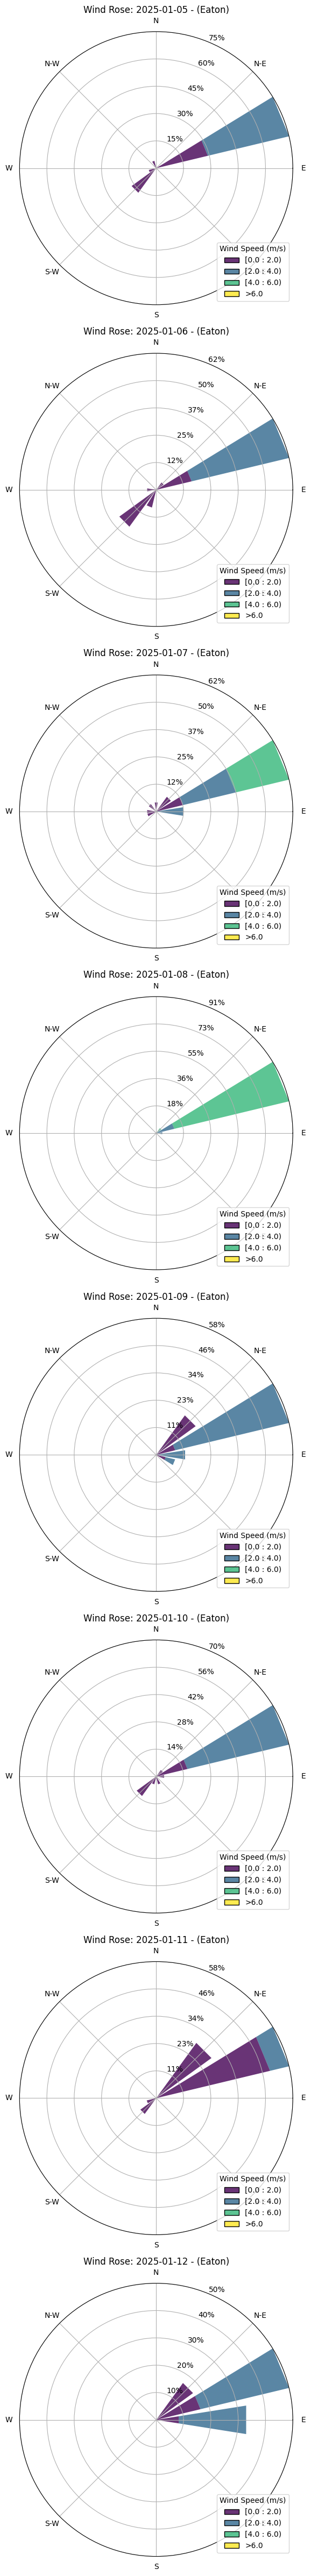

In [112]:
plot_wind_rose_per_day(eaton_u10_da_hour_mean, eaton_v10_da_hour_mean)

### For Palisades 

#### Select Days in January (5th to 12th Jan) 

In [113]:
palisades_u10_da = palisades_u10_da.sel(valid_time = slice('2025-01-05T00:00', '2025-01-12T23:00'))

palisades_v10_da = palisades_v10_da.sel(valid_time = slice('2025-01-05T00:00', '2025-01-12T23:00'))

#### Find Average across the pixels 

In [114]:
palisades_u10_da_hour_mean = palisades_u10_da.mean(dim = ['x', 'y'])

palisades_v10_da_hour_mean = palisades_v10_da.mean(dim = ['x', 'y'])

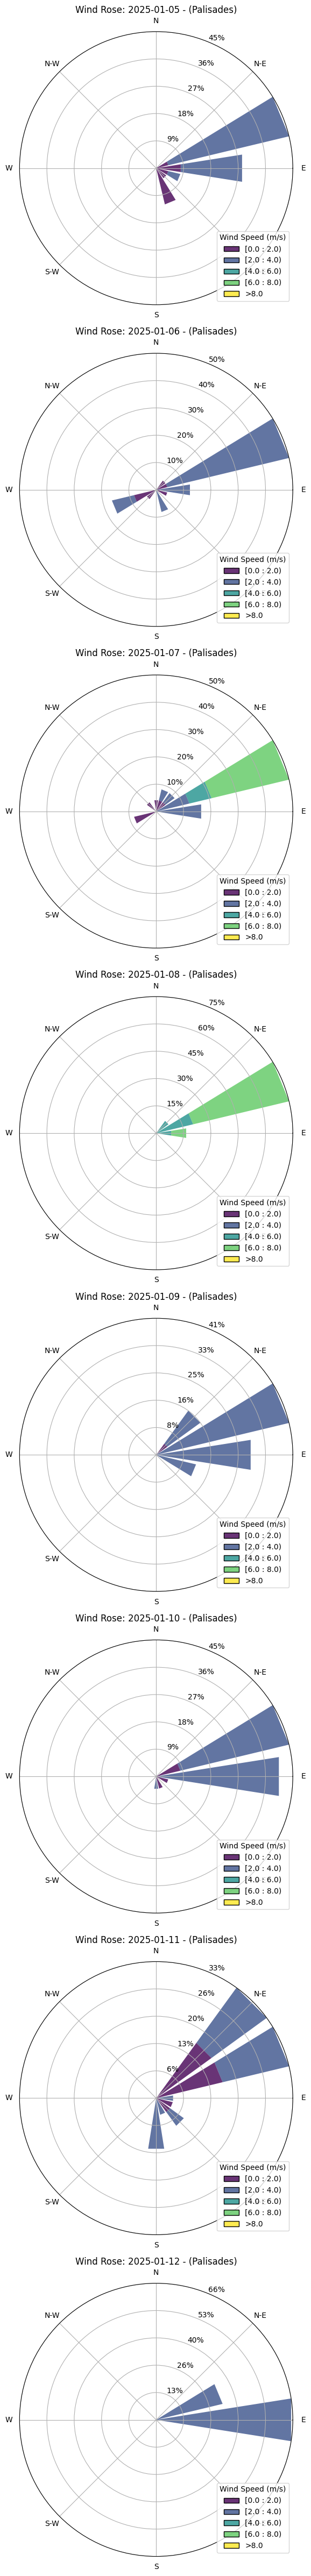

In [115]:
plot_wind_rose_per_day(palisades_u10_da_hour_mean, palisades_v10_da_hour_mean, 'Palisades')

### Wind Rose Interpretation  
* Color: Corresponds to different wind speed bins (e.g., 0-2 m/s, 2-4 m/s, etc.), typically using a colormap (cmap).
* Bar Length (Radius): Represents how often the wind blows from a specific direction.
* Concentric Circles: Usually indicate frequency, not wind speed.

### Findings 
* High winds observed on the 8th & 9th of January
* Wind directions were predominantly towards the East 

#### Export filt_study_area 

In [ ]:
# filt_study_area.to_file("filt_study_area.geojson", driver="GeoJSON")

#### Export Humidity xarray DataArray 

In [ ]:
# aqh2m.to_netcdf("humidity.nc")

#### Save Combined_Ds

In [ ]:
# combined_ds.to_netcdf('ERA_5_Land_Hourly_Data.nc')

### Reference articles 

https://www.climate.gov/news-features/event-tracker/weather-and-climate-influences-january-2025-fires-around-los-angeles#:~:text=In%20this%20context%2C%20he%20wrote,Cal%2DFire%2C%20via%20Flickr

Both fires erupted on Jan. 7, fueled by severe drought conditions and strong Santa Ana winds. After burning for 24 days, both fires were fully contained on Jan. 31, with over 37,000 acres burned and more than 16,000 structures destroyed.

* https://abc7.com/post/la-fires-aftermath-look-recovery-process-2-months-eaton-palisades/15988311/ 

### Findings From Analysis & Articles 
* High Evaporation means high heat / a lot of moisture leaving the ground & trees
* the weather conditions were not necessarily an ANOMALY
* lines up with the idea that something started the fires
* conditions prior had set up the area to have a lot of 'fuel':: a lot of rain which was followed by a dry spell 